### Abstract

I used the links below to get familiar with how to approach this task.

https://dev.meteostat.net/python/#example

https://www.anamind.com/anamind-blog/how-much-data-is-required-for-forecasting/

### Setup

In this section I download the Meteostat library which provides simple access to open weather and climate data

In [ ]:
!pip install meteostat

In this code block I import the most important libraries.

In [ ]:
import numpy as np
import pandas as pd
from pandas import  DateOffset
from sklearn import preprocessing

import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from datetime import datetime
from meteostat import Point, Daily

import matplotlib.pyplot as plt

### Load and prepare dataset

Downloading the dataset.

In [ ]:
# Defining the begining and the end of the dataset
end_date = datetime(2024, 10, 29)
start_date = end_date - DateOffset(years=2)

# Getting the location of Budapest
budapest = Point(47.4979, 19.0402)

# Getting the data
data = Daily(budapest, start_date, end_date)

# It returns a Pandas dataframe
data = data.fetch()

print(data.head())
print(f'\nNumber of samples: {len(data)}')
print(f'Number of columns: {len(data.columns)}')

            tavg  tmin  tmax  prcp  snow   wdir  wspd  wpgt    pres  tsun
time                                                                     
2022-10-29  11.8   9.1  15.2   0.0   NaN  221.0   5.6  18.5  1027.3   NaN
2022-10-30  12.6  10.5  16.2   0.0   NaN  277.0   3.6  13.0  1023.8   NaN
2022-10-31  11.5   9.3  14.2   0.0   NaN  135.0   4.6  14.8  1023.7   NaN
2022-11-01  10.7   8.9  14.1   0.0   NaN   61.0   7.7  20.4  1022.3   NaN
2022-11-02  13.0  10.2  17.0   0.1   NaN  294.0   8.4  24.1  1023.1   NaN

Number of samples: 732
Number of columns: 10


Here, I save the filltered dataset to a csv file.

In [ ]:
data.to_csv("weather-data.csv")

In this code block, I filter all the needed columns for fitting.

In [ ]:
columns = ['tmin', 'tmax']
window_size = 7

X_data = []
Y_data = []

for i in range(len(data) - window_size):
  X_sample = data[i:i+window_size][columns]
  X_sample = (X_sample[columns[0]] + X_sample[columns[1]])/2

  Y_sample = data.iloc[i+window_size][columns]
  Y_sample = (Y_sample[columns[0]] + Y_sample[columns[1]])/2

  X_data.append(X_sample)
  Y_data.append(Y_sample)

X_data = np.array(X_data)
Y_data = np.array(Y_data)

print(f'X_data shape: {X_data.shape}')
print(f'Y_data shape: {Y_data.shape}')

X_data shape: (725, 7)
Y_data shape: (725,)


In this section I create train, validation and test datasets.

In [ ]:
test_size = 0.1
validation_size = 0.1
number_of_samples = len(X_data)

test_start_idx = int(number_of_samples * (1 - test_size))
validation_start_idx = int(number_of_samples * (1 - test_size - validation_size))

X_train = X_data[:validation_start_idx]
Y_train = Y_data[:validation_start_idx]

X_valid = X_data[validation_start_idx:test_start_idx]
Y_valid = Y_data[validation_start_idx:test_start_idx]

X_test = X_data[test_start_idx:]
Y_test = Y_data[test_start_idx:]


scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

print(f'{X_train.shape}, {Y_train.shape}')
print(f'{X_valid.shape}, {Y_valid.shape}')
print(f'{X_test.shape}, {Y_test.shape}')

(580, 7), (580,)
(72, 7), (72,)
(73, 7), (73,)


### Defining and fitting the model

In this section, I create the model. By using multiple LSTM layers, the model can capture complex dependencies and temporal patterns in the data over varying time scales, which is crucial for capturing both short-term and long-term weather patterns.This model is a neural network using stacked Long Short-Term Memory (LSTM) layers, ideal for time-series forecasting, such as predicting weather. The architecture includes three LSTM layers with progressively fewer units (64, 32, and 16) to capture complex temporal patterns, along with Dropout layers to reduce overfitting. A final Dense layer outputs a single continuous value, suited for regression tasks like forecasting temperature or humidity. Compiled with mean squared error loss and mean absolute error as a metric, the model is tuned for accurate continuous predictions.

In [ ]:
model = keras.Sequential()
model.add(LSTM(units=64, return_sequences=True,  input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=32, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=16, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=1, activation="linear"))

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='mse',
              metrics=['mae'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 7, 64)               │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 7, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 7, 32)               │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 16)                  │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,465 (126.82 KB)

 Trainable params: 32,465 (126.82 KB)

 Non-trainable params: 0 (0.00 B)

Defining callbacks for the fitting process.

In [ ]:
checkpointer = ModelCheckpoint(filepath='weights.keras', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(patience=10, verbose=1)

In this code block, I fit the model, choosing a small batch size to achieve a more precise fitting process.

In [ ]:
history = model.fit(X_train, Y_train,
          epochs=55,
          batch_size=16,
          validation_data=(X_valid, Y_valid),
          callbacks = [early_stopping, checkpointer],
          verbose=2,
          shuffle=True)

Epoch 1/55

Epoch 1: val_loss improved from inf to 414.77444, saving model to weights.keras
37/37 - 14s - 385ms/step - loss: 178.7995 - mae: 11.3987 - val_loss: 414.7744 - val_mae: 20.1580
Epoch 2/55

Epoch 2: val_loss improved from 414.77444 to 347.86243, saving model to weights.keras
37/37 - 2s - 63ms/step - loss: 114.9106 - mae: 8.6755 - val_loss: 347.8624 - val_mae: 18.4227
Epoch 3/55

Epoch 3: val_loss improved from 347.86243 to 319.03754, saving model to weights.keras
37/37 - 1s - 17ms/step - loss: 93.4727 - mae: 7.6221 - val_loss: 319.0375 - val_mae: 17.6230
Epoch 4/55

Epoch 4: val_loss improved from 319.03754 to 295.99438, saving model to weights.keras
37/37 - 1s - 17ms/step - loss: 84.6708 - mae: 7.1788 - val_loss: 295.9944 - val_mae: 16.9567
Epoch 5/55

Epoch 5: val_loss improved from 295.99438 to 275.96127, saving model to weights.keras
37/37 - 1s - 16ms/step - loss: 76.6351 - mae: 6.8042 - val_loss: 275.9613 - val_mae: 16.3553
Epoch 6/55

Epoch 6: val_loss improved from 27

Here, I evaluate the fitting.

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 337ms/step


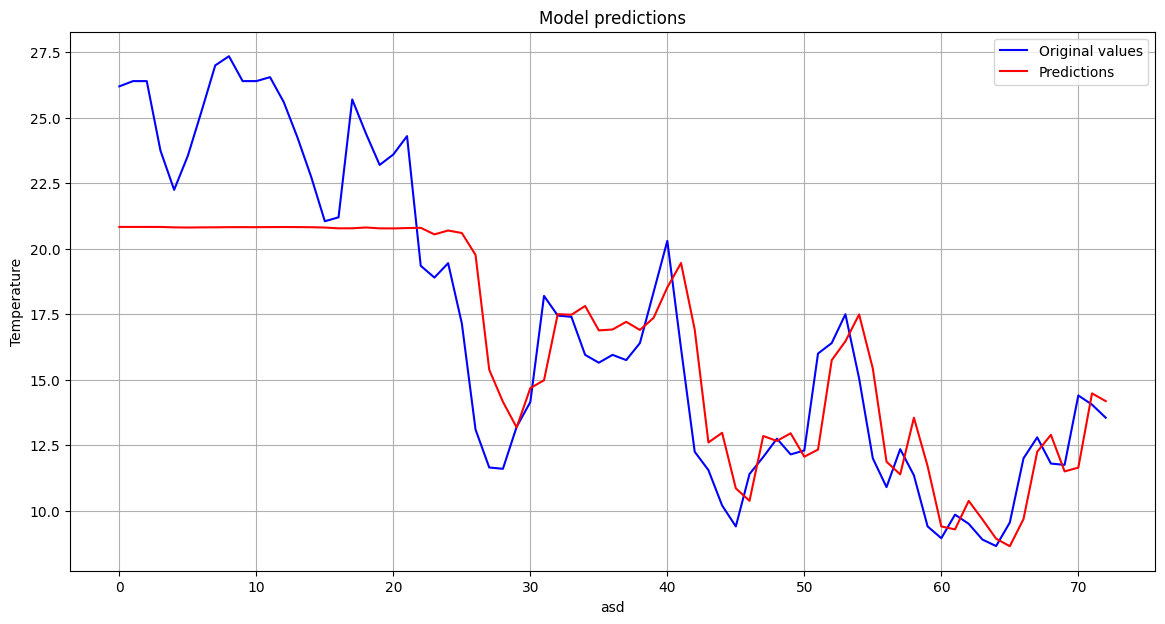

In [ ]:
Y_pred = model.predict(X_test)

plt.figure(figsize=(14, 7))
plt.plot(Y_test, label='Original values', color='blue')
plt.plot(Y_pred, label='Predictions', color='red')
plt.title('Model predictions')
plt.ylabel('Temperature')
plt.xlabel('asd')
plt.legend()
plt.grid()
plt.show()

Here, I predict the temperature for nov 6,7 and 8.

In [ ]:
# Prepare input for prediction
start = datetime(2024, 10, 30)  # Start date for data fetching
end = datetime(2024, 11, 5)     # End date for data fetching
budapest = Point(47.4979, 19.0402)  # Coordinates for Budapest

# Fetching the daily weather data for Budapest within the specified date range
data = Daily(budapest, start, end)
data = data.fetch()

# Calculate the average temperature for each day by averaging minimum and maximum temperatures
input_data = (data['tmin'] + data['tmax']) / 2
input_array = np.array(input_data)  # Convert to a NumPy array for processing

# Calculate the standard deviation and mean of the entire dataset for normalization
std = input_array.std()
mean = input_array.mean()

# Standardize (normalize) the data by subtracting the mean and dividing by the standard deviation
input_array_std = (input_array - mean) / std

# Reshape the input data to match the model's expected input shape (1 sample, 7 features)
input_array_std = np.array([input_array_std])

# Make a prediction for November 6 based on the standardized data
prediction_nov6 = model.predict(input_array_std)

# Prepare input data for the November 7 prediction
# Append the November 6 prediction to the last 6 days of actual data
input_array0 = np.append(input_array[-6:], prediction_nov6)

# Calculate the mean and standard deviation of the new 7-day sequence (including the prediction)
mean0 = input_array0.mean()
std0 = input_array0.std()

# Standardize the updated 7-day input data
input_array_std0 = (input_array0 - mean0) / std0

# Reshape the data for the model input (1 sample, 7 features)
input_array_std0 = np.array([input_array_std0])

# Make a prediction for November 7 using the updated input
prediction_nov7 = model.predict(input_array_std0)

# Prepare input data for the November 8 prediction
# Append the predictions for November 6 and 7 to the last 5 days of actual data
input_array1 = np.append(input_array[-5:], [prediction_nov6, prediction_nov7])

# Calculate the mean and standard deviation for this new 7-day sequence (including predictions)
mean1 = input_array1.mean()
std1 = input_array1.std()

# Standardize the input for November 8 prediction
input_array_std1 = (input_array1 - mean1) / std1

# Reshape the data for the model input (1 sample, 7 features)
input_array_std1 = np.array([input_array_std1])

# Make a prediction for November 8 using the updated input
prediction_nov8 = model.predict(input_array_std1)

# Print out the predictions for November 6, 7, and 8
print("Prediction for November 6:", prediction_nov6)
print("Prediction for November 7:", prediction_nov7)
print("Prediction for November 8:", prediction_nov8)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Prediction for November 6: [[5.129234]]
Prediction for November 7: [[7.72457]]
Prediction for November 8: [[14.610555]]
